# Writing elegant Python

In [1]:
%run preamble.py

In any programming language you can write incomprehensible code. This is not a good thing - whether it is possible to understand how your code works, or even to update it is dependent on the way you write your code. Happily working in Python it is easy to write elegant code.

Writing elegant code means two things:

1. Writing the minimum amount of code possible to achieve your goal in the most efficient way possible.
2. Writing code that conforms to a shared standard and understanding with meaningful variable and classnames, that is well documented, and intended to be usable long into the future.

This section includes practical examples of updating common code patterns to be as efficient and elegant as possible.

In [9]:
# Load data:
apple = pd.read_hdf('Data/AAPL.h5')
forbes = pd.read_csv('Data/forbes1964.csv').set_index('name')

## Iterate through sequences, not indices

Python iterators return element at a time from any sequence being iterated over. Having to create a sequence of indexes just to extract values from a sequence is a wasted step.

In [10]:
# Not:
for i in range(len(apple.columns)):
    col_name = apple.columns[i]
    print(col_name, end='|')

Open|High|Low|Close|Volume|Adj Close|

In [11]:
# Instead:
for col_name in apple.columns:
    print(col_name, end='|')

Open|High|Low|Close|Volume|Adj Close|

## Use `zip()` to iterate through sequences in lockstep

Often a reason for creating sequences containing nothing but indexes is to extract data from more than one collection at once. In Python this is not needed - instead in Python you can use `zip` to extract values fro  sequences in lockstep.

In [12]:
countries = ['Australia', 'Netherlands', 'China', 'Mozambique']
capitals = ['Canberra', 'Amsterdam', 'Beijing', 'Maputo']
populations = [24598933, 17132854, 1386395000, 29668834]  # 2017 population, source: World Bank

In [13]:
for country, capital, pop in zip(countries, capitals, populations):
    print(country, capital, pop, sep='|')

Australia|Canberra|24598933
Netherlands|Amsterdam|17132854
China|Beijing|1386395000
Mozambique|Maputo|29668834


Especially useful: use `zip()` to construct dictionaries from two sequences

In [14]:
dict(zip(countries, populations))

{'Australia': 24598933,
 'Netherlands': 17132854,
 'China': 1386395000,
 'Mozambique': 29668834}

Or to invert a dictionary

In [15]:
colour_codes = {'r': 'red', 'b': 'blue', 'k': 'black', 'y': 'yellow'}

In [16]:
# To invert it:
colour_codes_inv = dict(zip(colour_codes.values(), colour_codes.keys()))

Check that there are no duplicate keys, though: these would be overwritten.

In [17]:
assert len(colour_codes) == len(colour_codes_inv)

In [18]:
airports = pd.read_csv('./Data/airports.csv')

In [19]:
airports[:3]

Airport_ID         Name         City           Country IATA_FAA  ICAO  \
0           1       Goroka       Goroka  Papua New Guinea      GKA  AYGA   
1           2       Madang       Madang  Papua New Guinea      MAG  AYMD   
2           3  Mount Hagen  Mount Hagen  Papua New Guinea      HGU  AYMH   

   Latitude   Longitude  Altitude  Timezone DST       Tz_db_time_zone  
0 -6.081689  145.391881      5282      10.0   U  Pacific/Port_Moresby  
1 -5.207083  145.788700        20      10.0   U  Pacific/Port_Moresby  
2 -5.826789  144.295861      5388      10.0   U  Pacific/Port_Moresby

In [20]:
# E.g. map the 3-letter code to the 4-letter ICAO code:
airport_codes = dict(zip(airports['IATA_FAA'], airports['ICAO']))

In [21]:
def get_size(file):
    return os.stat(file).st_size

files = glob.glob('/data/*')
sizes = [get_size(file) for file in files]
# More code here ...

If you later want a dictionary mapping filenames to their sizes, use:

In [22]:
filesizes = dict(zip(files, sizes))

Check again for duplicate keys:

In [23]:
assert len(filesizes) == len(files)

## Using the (extended) unpacking syntax

Python makes it very easy to unpack variables from collections, which is particularly useful when getting multiple values back from functions:

In [24]:
import requests

def get_longitude_latitude(city):
    url = 'https://llinvfu1jc.execute-api.ap-southeast-2.amazonaws.com/dev/location/query'
    params = {'name': city}
    response = requests.get(url, params)
    response.raise_for_status()
    location = response.json()
    return location['longitude'], location['latitude']

In [25]:
get_longitude_latitude('Batemans Bay')

(150.207306681, -35.6896187146)

In [26]:
x, y = get_longitude_latitude('Batemans Bay')

In [27]:
# Swap them:
(y, x) = (x, y)

This is also commonly encountered in loops, particularly when using `zip` (see above) or `enumerate`.

In [28]:
# In loops:
for (i, col_name) in enumerate(forbes.columns):
    print(i, col_name)

0 rank
1 country
2 sales
3 profits
4 assets
5 marketvalue


### Elegant unpacking of arrays

In [29]:
# Unpacking combined with transpose:
profits, marketvalue = forbes[['profits', 'marketvalue']].dropna().values.T

### Limiting parameters

The extended unpacking syntax allows you to use `*` arguments to allow partial unpacking. The `*` argument can be used anywhere, but only once:

In [30]:
# Extended unpacking:
slope, intercept, *_, = stats.linregress(profits, marketvalue)

In [31]:
slope, intercept

(7.426327725367626, 8.971530346546103)

In [32]:
slope, *_, stderr = stats.linregress(profits, marketvalue)
slope, stderr

(7.426327725367626, 0.2621443490142193)

In [33]:
*_, stderr = stats.linregress(profits, marketvalue)

### Exercise: write a wrapper function for `plt.plot(xs, ys, ...)` called `newplot` that takes a `transpose` keyword argument

In [34]:
def newplot(xs, ys, transpose=False):
    if transpose:
        ys, xs = xs, ys
    plt.plot(xs, ys)

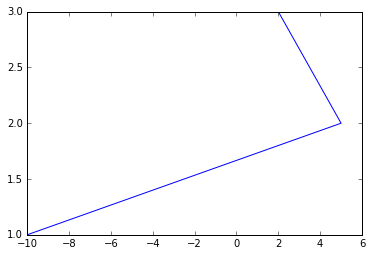

In [35]:
newplot([1, 2, 3], [-10, 5, 2], transpose=True)

## Argument expansion in function calls

Similar to argument unpacking, Python allows for argument expansion in function calls using `*` arguments to expand an iterable:

In [36]:
# This:
print(*forbes.columns, sep=',')

rank,country,sales,profits,assets,marketvalue


In [37]:
# versus this:
print(','.join(forbes.columns))

rank,country,sales,profits,assets,marketvalue


Python also allows for the use of `**` arguments to expand dictionaries as keyword arguments:

In [38]:
params = {'sep': '|', 'end': '!'}
print(*forbes.columns, **params)

rank|country|sales|profits|assets|marketvalue!

## Use namedtuples (if immutable)

The previous example gave this:

In [39]:
params = stats.linregress(profits, marketvalue)

In [40]:
params

LinregressResult(slope=7.426327725367626, intercept=8.971530346546103, rvalue=0.538988185427957, pvalue=2.831606318704309e-148, stderr=0.2621443490142193)

This is a `namedtuple`. You can use this as follows:

In [41]:
params.slope, params.intercept, params.stderr

(7.426327725367626, 8.971530346546103, 0.2621443490142193)

which is more readable than this:

In [42]:
params[0], params[1], params[4]

(7.426327725367626, 8.971530346546103, 0.2621443490142193)

The `namedtuple` constructor is found in the inbuilt `collections` module:

In [43]:
from collections import namedtuple

A named tuple object is created with an object type name, which should be a valid Python identifier, and a list of field names. Once you have created the named tuple you can create an instance by passing either positional or keyword arguments. For example:

In [44]:
Currency = namedtuple('Currency', ['name', 'central_bank', 'symbol'])

In [45]:
euro = Currency('Euro', 'European Central Bank', '€')
euro

Currency(name='Euro', central_bank='European Central Bank', symbol='€')

In [46]:
aus_dollar = Currency('Australian Dollar', 'Reserve Banks of Australia', '$')
aus_dollar

Currency(name='Australian Dollar', central_bank='Reserve Banks of Australia', symbol='$')

In [47]:
aus_dollar.central_bank

'Reserve Banks of Australia'

### Exercise: Building named tuples

1. Create your own `namedtuple` type to represent the following stats about a `DataFrame`: number of rows, number of columns, number of duplicated index values, total memory usage
2. Write a function that returns a new instance of your namedtuple for a given `DataFrame`